## Imports

In [ ]:
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/hour.csv
!pip install simple-colors

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.linear_model import HuberRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from simple_colors import *
from sklearn.linear_model import LinearRegression, Ridge, Lasso

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 7)
%matplotlib inline
warnings.filterwarnings("ignore")

## Dataset

Dataset is about bike rental service. It contains bike sharing counts aggregated on hourly basis. Total number of records: 17379 hours (2 years of rental services). There are following features:
- instant: record index
- dteday : date of record
- hr : hour (0 to 23) of record
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : weather situation in the current timeframe
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users (target 1)
- registered: count of registered users (target 2)
- cnt: count of total rental bikes including both casual and registered (target total)

In [ ]:
# Reading the data
data = pd.read_csv('hour.csv', index_col='instant')

In [ ]:
data.head(100)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2011-01-05,1,0,1,4,0,3,1,1,0.24,0.2273,0.48,0.2239,0,2,2
97,2011-01-05,1,0,1,5,0,3,1,1,0.22,0.2273,0.47,0.1642,0,3,3
98,2011-01-05,1,0,1,6,0,3,1,1,0.20,0.1970,0.47,0.2239,0,33,33


## Task

- Preprocessing
- Feature engineering 
- Use different advanced regression algorithms:
    - KNN Regressor 
    - Decision Tree Regressor 
    - Random Forest / Extra Trees Regressor (1 point)
    - SVM Regressor (1 point)
    - Boosting Regressor - any Boosting algorithm with Regression (1 point)
    - Any other regression algorithm besides Linear, Ridge, Lasso and used above. (1 point)

NB! The task is considered done for each model if there is hyperparameters tuning and validation is used. 
- Build regression model for each year in question (2 points):
    - Target is cnt, exclude casual and registered from the model
    - Validate either on last 7 days of each months or on random subsample
    - Check the quality of prediction
    - Build regression model based on the first year data and make predictions for the second year (you should validate first year model on itself, similarly to previous task) . The results are better or worse? Why? (1 point)
- Build regression model for each year in question (2 points):
    - Multitarget: casual and registered, exclude cnt from the model
    - Validate either on last 7 days of each months or on random subsample
    - Check the quality of prediction
    - Use the sum of two targets two predict cnt. Estimate the quality. Is it higher than for one-target model? (1 point)
- In the process of completion, answer the following questions:
    - How the temperature and humidity influences rental count rates? What is more important - temperature or feeling temperature? (2 point)
    - What are the most influentual features? (2 points)
    - What is more important: current season or current hour? (1 point)

Total points: 20. Threshold for completion: 15 points.    

# Functions

Some useful functions which will be used in the tasks

In [ ]:
# Function for plotting categorical features
def plot_cat(df, col, target):
  for c in col:
    fig, ax = plt.subplots(figsize = (15, 5))
    sns.boxplot(x = c, y = target, data = df, orient = 'v')
    ax.set_title(f'{c} vs target')

In [ ]:
# Function for deleting rows with outliers due to 1.5IQR rule
def drop_outliers(data, column):
    Q1, Q3 = np.percentile(column,[25,75])
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5*IQR)
    upper_limit = Q3 + (1.5*IQR)
    data.drop(data[column<lower_limit].index, inplace=True)
    data.drop(data[column>upper_limit].index, inplace=True)
    print('Outliers deleted')

In [ ]:
# Function for fitting and estimating model
def fit_est_model(X_tr, y_tr, X_ts, y_ts, model, title):
  model.fit(X_tr, y_tr)
  y_pred = model.predict(X_ts)
  print(red(title, ['bold']))
  print('R2:', blue(r2_score(y_ts, y_pred), ['bold']))
  print('RMSE', np.sqrt(mean_squared_error(y_ts, y_pred)))
  return y_pred

In [ ]:
# Function for cross_validation of the model
def cross_validate_r2(model, X_v, y_v, cv):
   scores = cross_val_score(model, X_v, y_v, scoring='r2', cv=cv)
   scores = pd.Series(scores)
   return scores.mean()

In [ ]:
# Function for grid search and finding best estimator
def grid_search_cv(model, params, cv, scoring, X, y):
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv = cv, verbose = 1,
                            scoring = scoring, n_jobs = -1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_

In [ ]:
# Helper function to compute cross validation scores
def cross_validate(model, X, Y, cv, scoring):
    x_val_score = cross_val_score(model, X, Y, cv = cv, n_jobs = -1, scoring = scoring)
    if scoring == 'neg_mean_squared_error':
      x_val_score = np.round(np.sqrt(-1*x_val_score), 5)
    else:
      x_val_score = np.round(x_val_score, 5)
    return x_val_score.mean()

# Function to plot cross validation scores for list of models
def plot_cv_scores(models_list, indexes_list, X, Y, cv, scoring):
    # Calculate cross validation score of differnt models
    cross_val_scores = []
    for model in models_list:
        cross_val_scores.append(cross_validate(model, X, Y, cv, scoring))

    # Plot data frame of cross validation scores
    x_val_score = pd.DataFrame(data = cross_val_scores, columns = ['CV Scores'])
    x_val_score.index = indexes_list
    x_val_score = x_val_score.round(5)
    x = x_val_score.index
    y = x_val_score['CV Scores']
    sns.barplot(x=x, y=y)
    if scoring == 'neg_mean_squared_error':
      plt.title('RMSE')
    else:
      plt.title(f'{scoring.title()}')

In [ ]:
# Function for plotting feature importance
def plot_importance(est, colnames, title, top_n=20):
    importance = pd.DataFrame({
        'Weight': np.abs(est.feature_importances_),
        'Features': colnames})
    imp20 = importance.sort_values(by='Weight', ascending=False)[:top_n]
    sns.barplot(y='Features', x='Weight', data=imp20, orient='h')
    plt.title(f'Feature importance for {title}')

In [ ]:
# Functions for scores of sum for multitarget model
def scores(y_real, y_pred):
  print(red('Sum reg+cas', ['bold'])) 
  print('R2:', blue(r2_score(y_real, y_pred), ['bold']))
  print('RMSE', np.sqrt(mean_squared_error(y_real, y_pred)))

In [ ]:
def plot_cv_mean_per_model(cv_scores_list, models_list):
  df_scores = pd.DataFrame(data = cv_scores_list, columns = ['CV Scores'])
  df_scores.index = models_list
  df_scores = df_scores.round(5)
  x = df_scores.index
  y = df_scores['CV Scores']
  sns.barplot(x=x, y=y)
  plt.title('Cross-validation R2(means) for models')

# EDA, preprocessing, feature engineering


First we have date type feature, month and year is already extracted from it, so only day of month left to extract

In [ ]:
# Checking datatypes of dataset - dteday is object, so we need to convert it
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.3+ MB


In [ ]:
# Converting dteday column to datetime format and extracting day of month
data.dteday = pd.to_datetime(data.dteday.astype(str), format='%Y-%m-%d')
data['day_of_month'] = data.dteday.dt.day

# Dropping dteday feature as it isn't needed anymore
data.drop('dteday', axis=1,  inplace =True)

Now I'll check if there are any missing values

In [ ]:
# Percentage of missing values for each feature
data.isna().sum()/len(data)

season          0.0
yr              0.0
mnth            0.0
hr              0.0
holiday         0.0
weekday         0.0
workingday      0.0
weathersit      0.0
temp            0.0
atemp           0.0
hum             0.0
windspeed       0.0
casual          0.0
registered      0.0
cnt             0.0
day_of_month    0.0
dtype: float64

No missing values as we can see

## Target

In [ ]:
# Checking target statistics
data.cnt.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

Text(0.5, 1.0, 'Target distribution')

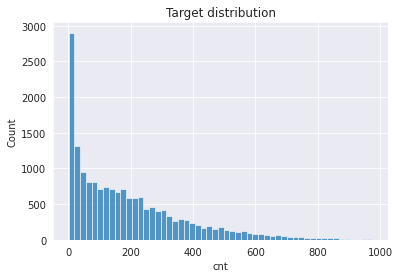

In [ ]:
# Visualization for target distribution
sns.histplot(data=data, x='cnt')
plt.title('Target distribution')

As we can see target has skewed distribution, main amount of data is between 40 and 282 counts

## Categorical features

In [ ]:
# Creating lists for categorical and numerical features
columns_cat = ['season', 'yr', 'mnth',
               'hr', 'holiday', 'weekday',
               'workingday', 'weathersit', 
               'day_of_month']
 
columns_num = ['temp', 'atemp', 'hum', 'windspeed']

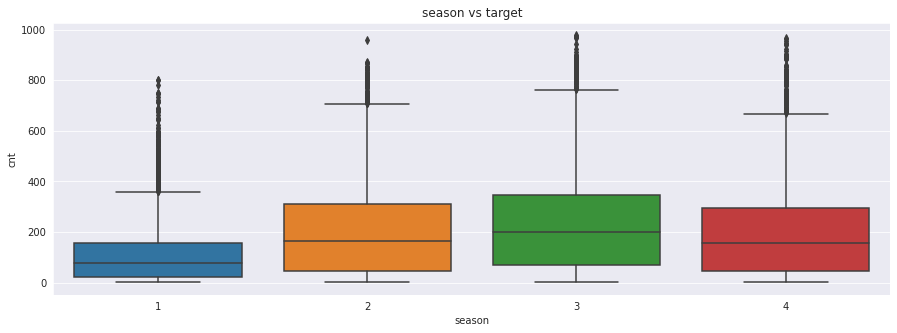

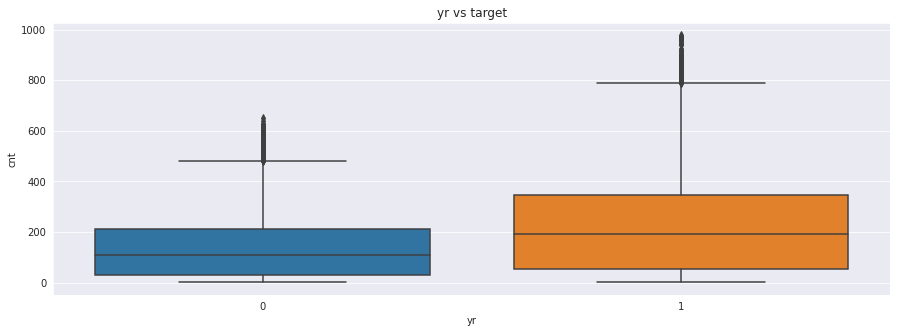

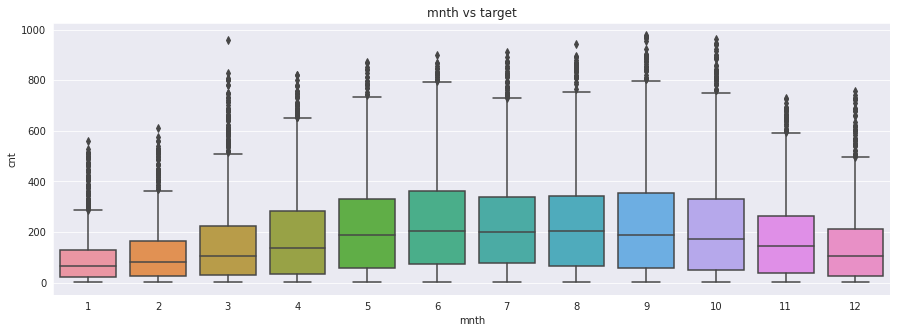

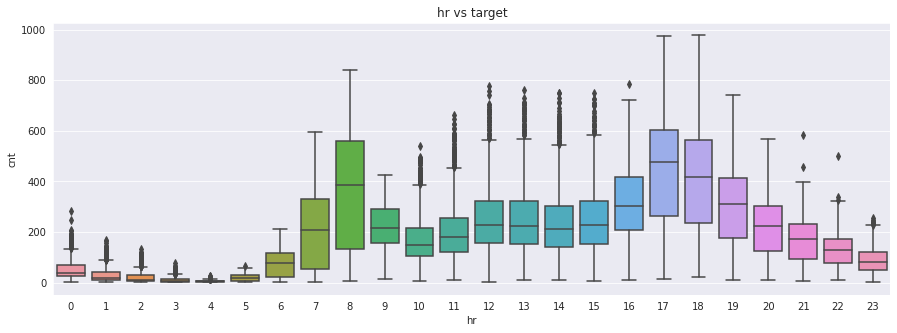

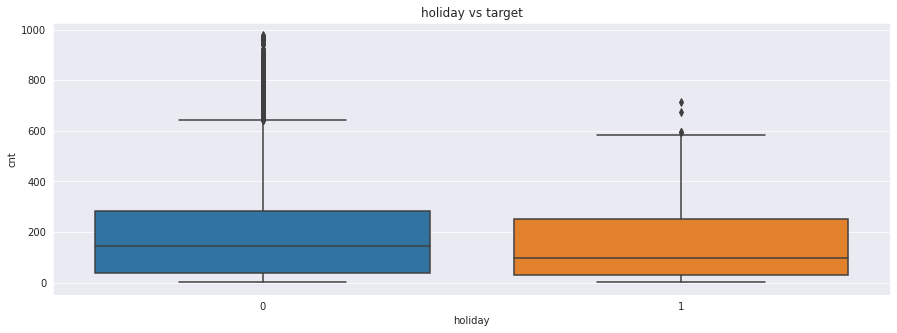

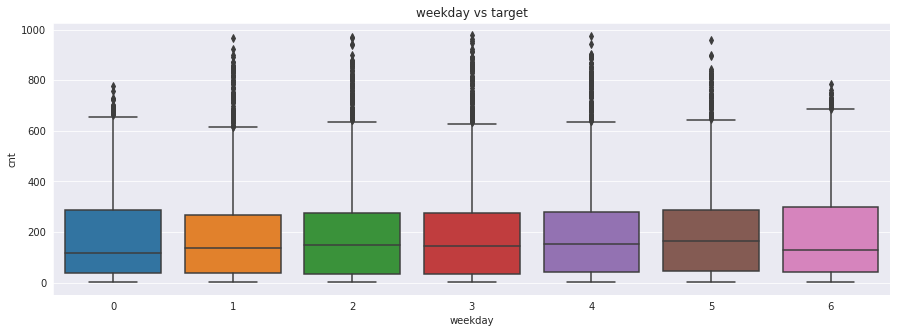

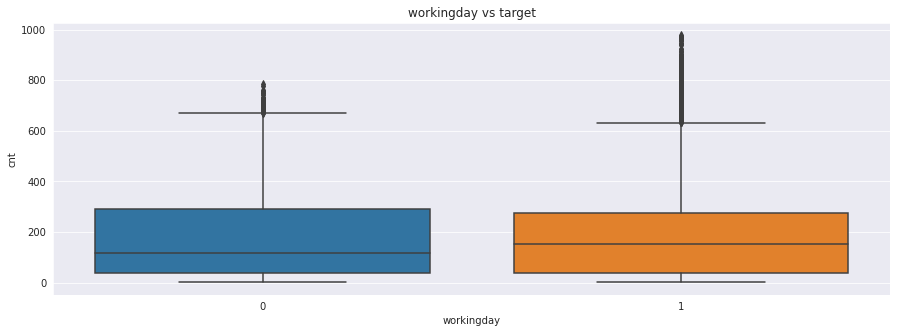

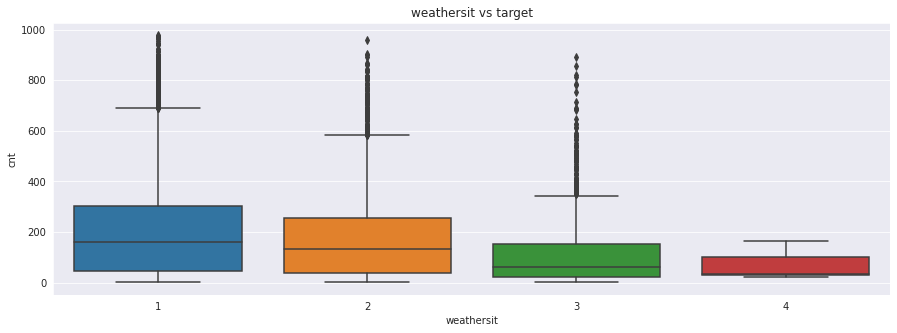

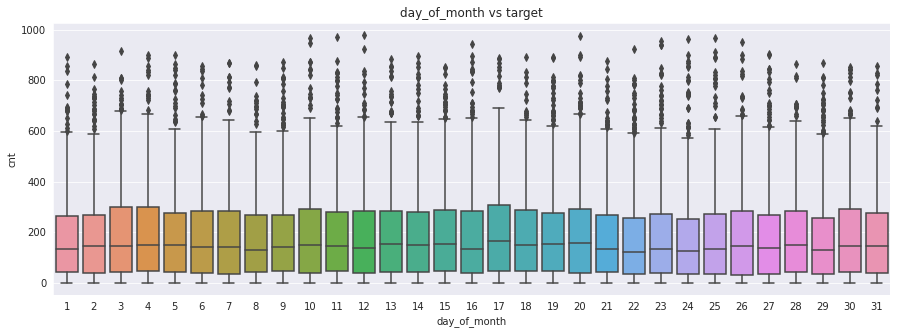

In [ ]:
# Visualization for categorical features vs cnt feature
plot_cat(data, columns_cat, 'cnt')

From visualization looks like important features for target are season/month, year, hour and weathersit

## Numerical features

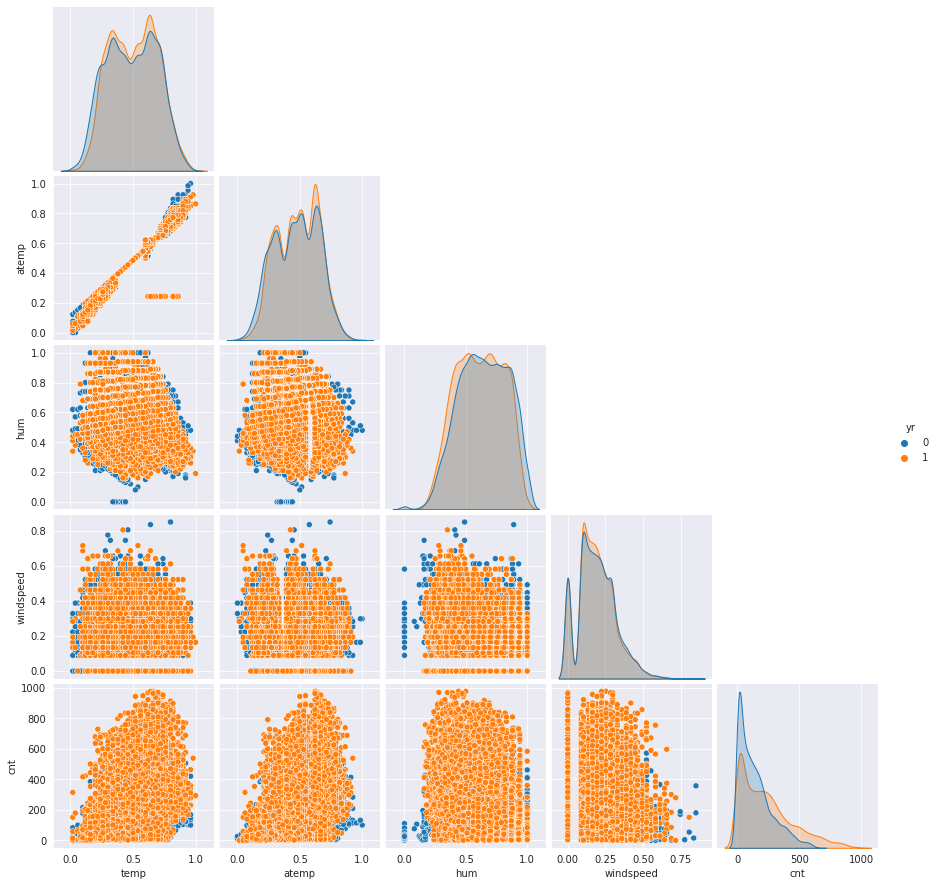

In [ ]:
# Visualization for target vs some numerical features relations
col_num_all = columns_num.copy()
col_num_all.append('cnt')
sns.pairplot(
    data,
    x_vars=col_num_all,
    y_vars=col_num_all,
    corner=True, 
    hue = 'yr'
)

* From this plot we can see that atemp and temp are highly correlated and it would be good to eliminate one of those features to avoid multicollinearity, but as we have in the task to check both so they will stay for now
* Also we can see that numerical features are not perfectly normal, will try to transform them in next section
* Also difference from 2011 to 2012 year for numerical features is very small

Despite we have a lot categorical features which are just encoded numerical still correlation will be checked but with attention to numerical features

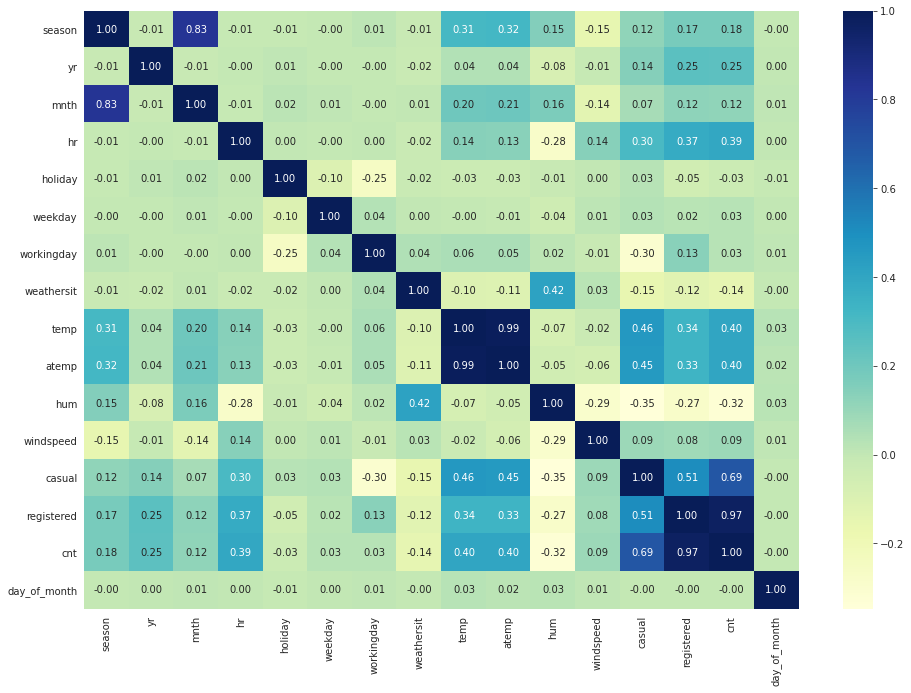

In [ ]:
# Visualization for checking correlation
corr = data.corr() 
plt.figure(figsize = (16 , 11)) 
sns.heatmap(corr, annot=True, fmt='.2f', cmap="YlGnBu");

* Here we can see that cnt is highly correlated with casual and registered and this is expected as they are the same just if to sum. Anyway models will be build for those targets separately. 
* Also important for cnt are hr, temp/atemp, hum, yr
* Some features are just noise and are not connected with target, so few of them will be dropped

In [ ]:
# Dropping some not correlated features
data.drop('day_of_month', axis=1,  inplace =True)
columns_cat.remove('day_of_month')
data.drop('holiday', axis=1,  inplace =True)
columns_cat.remove('holiday')

## Outliers detection

In [ ]:
# Statistics for numerical features
data[columns_num].describe()

,temp,atemp,hum,windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098
std,0.192556,0.171850,0.192930,0.122340
min,0.020000,0.000000,0.000000,0.000000
25%,0.340000,0.333300,0.480000,0.104500
50%,0.500000,0.484800,0.630000,0.194000
75%,0.660000,0.621200,0.780000,0.253700
max,1.000000,1.000000,1.000000,0.850700


* As we can see almost for every feature we have ouliers
* For dropping them we select method with 1.5(IQR) as it deletes extreme values, but still left pretty much rows which can be useful for other features

In [ ]:
# Deleting extreme outliers
drop_outliers(data, data['temp'])
drop_outliers(data, data['atemp'])
drop_outliers(data, data['hum'])
drop_outliers(data, data['windspeed'])


Outliers deleted
Outliers deleted
Outliers deleted
Outliers deleted


## Transformation

In [ ]:
# Separating train and target
target = data.cnt
train = data.drop(['cnt', 'registered', 'casual'], axis=1)

As our numerical data is skewed we can check some transformations with plot visualization

In [ ]:
# log, power and squre root transformation of data
log_df = np.log1p(train[columns_num])
power_df = np.power(train[columns_num], 2)
sqrt_df = np.sqrt(train[columns_num])

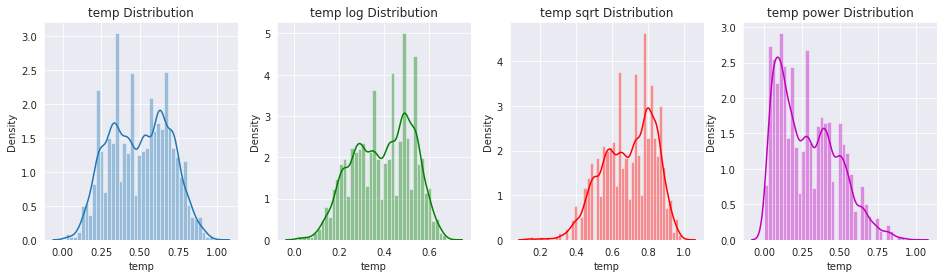

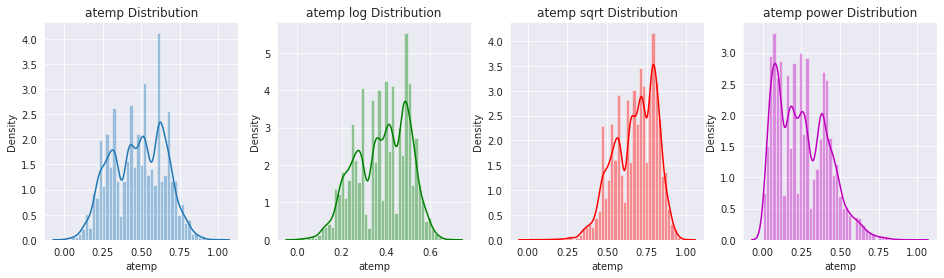

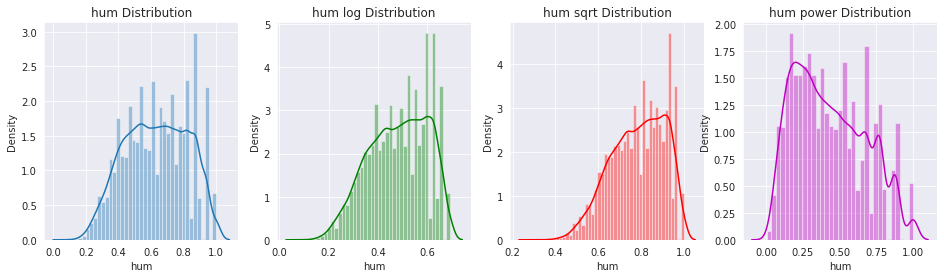

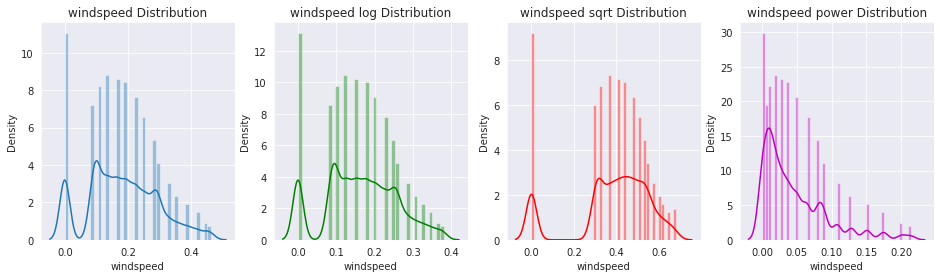

In [ ]:
# Visualization for features ditribution comparing after log, power and sqrt transformation
for feature in columns_num:

    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    sns.distplot(train[feature])
    plt.xlabel(feature)
    plt.title(f'{feature} Distribution')

    plt.subplot(1,4,2)
    sns.distplot(log_df[feature], color='g')
    plt.xlabel(feature)
    plt.title(f'{feature} log Distribution')

    plt.subplot(1,4,3)
    sns.distplot(sqrt_df[feature], color='r')
    plt.xlabel(feature)
    plt.title(f'{feature} sqrt Distribution')

    plt.subplot(1,4,4)
    sns.distplot(power_df[feature], color='m')
    plt.xlabel(feature)
    plt.title(f'{feature} power Distribution')

* As we can see given tranformation didn't resulted in any better distribution and smaller skeweness
* Also there is no need for scalling as our numerical features are already normalized

# Models

First models for all dataset will be done, and in next sections dataset will be divided by year 


## Baseline for all models

* First basic models for all types will be build, then hyperparameters tunning will be done for every model
* As BoostingRegressor LGBMRegressor is used
* As additional model HuberRegressor is added
* As metrics R2 and RMSE will be checked
* Validation can be done on random subsample due to information in the task


In [ ]:
# Splitting training dataset onto train and validation subsets
train_X, val_X, train_y, val_y = train_test_split(train, target, test_size = 0.20, random_state=0)

In [ ]:
# Models before hyperparameters tunning
knr = KNeighborsRegressor(n_neighbors=1)
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
lgbm = LGBMRegressor()
svr = SVR()
hub = HuberRegressor()

In [ ]:
# Fitting and estimating basic models
fit_est_model(train_X, train_y, val_X, val_y, knr, 'KNR')
fit_est_model(train_X, train_y, val_X, val_y, dtr, 'DTR')
fit_est_model(train_X, train_y, val_X, val_y, rfr, 'RFR')
fit_est_model(train_X, train_y, val_X, val_y, lgbm, 'LGBM')
fit_est_model(train_X, train_y, val_X, val_y, svr, 'SVR')
e = fit_est_model(train_X, train_y, val_X, val_y, hub, 'HUB')

KNR
R2: 0.8311218089199905
RMSE 75.46954467805568
DTR
R2: 0.8815738026662727
RMSE 63.19880082234079
RFR
R2: 0.9416551367032485
RMSE 44.35946083677632
LGBM
R2: 0.9488866606414366
RMSE 41.51949602650679
SVR
R2: 0.3739756365193989
RMSE 145.305001496176
HUB
R2: 0.3670620818419199
RMSE 146.10514268538512


Here we can see that RandomForestRegressor and LGBMRegressor gave the best scores, but let's check them after hyperparameters tunning

## Hyperparameters tunning

First some hyperparameters tunning will be done for every model with crid search and then in the end all models will be estimated and cross-validation will be done.

### KNeighborsRegressor

In [ ]:
# Creating dictionary of hyperparameters that we want to tune for KNR
leaf_size = list(range(1, 10, 2))
n_neighbors = list(range(1,10))
p=[1,2]
weights = ['distance', 'uniform']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
knr_param = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, weights=weights, p=p, algorithm=algorithm)

In [ ]:
%%time
# Grid search for the model
knr_best = grid_search_cv(knr, knr_param, 5, 'r2', train_X, train_y)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  8.0min


CPU times: user 40 s, sys: 3.91 s, total: 43.9 s
Wall time: 10min 53s


[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 10.9min finished


### DecisionTreeRegressor

In [ ]:
# Dictionary of hyperparameters that we want to tune for DTR
dtr_param = {
    'max_depth': [5, 10, 20],
    'max_features': [2, 10, 15],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 6, 12]}

In [ ]:
%%time
# Grid search for the model
dtr_best = grid_search_cv(dtr, dtr_param, 5, 'r2', train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    4.2s


CPU times: user 1.13 s, sys: 96.7 ms, total: 1.23 s
Wall time: 6.67 s


[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:    6.6s finished


### RandomForestRegressor

In [ ]:
# Dictionary of hyperparameters that we want to tune for RFR
rfr_param = {
    'max_depth': [5, 10, 20],
    'max_features': [2, 10],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [2, 12],
    'n_estimators': [10, 100, 600, 1000]}

In [ ]:
%%time
# Grid search for the model
rfr_best = grid_search_cv(rfr, rfr_param, 5, 'r2', train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 40.7min finished


CPU times: user 1min 9s, sys: 2.97 s, total: 1min 12s
Wall time: 41min 30s


### LGBMRegressor

In [ ]:
# Dictionary of hyperparameters that we want to tune for LGBM
lgbm_param = {
        'bagging_fraction': (0.5, 0.8),
        'bagging_frequency': (5, 8),
        'feature_fraction': (0.5, 0.8),
        'max_depth': (5, 10, 13),
        'min_data_in_leaf': (90, 120),
        'num_leaves': (1200, 1550),
        'n_estimators': (100, 1000, 2000)}

In [ ]:
%%time
# Grid search for the model
lgbm_best = grid_search_cv(lgbm, lgbm_param, 5, 'r2', train_X, train_y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 45.3min finished


CPU times: user 39.1 s, sys: 3.48 s, total: 42.6 s
Wall time: 45min 24s


### SVR

In [ ]:
# Dictionary of hyperparameters that we want to tune for SVR
svr_param = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # precomputed is omitted from kernel to avoid error.
    'C': [4, 20, 100], 
    'gamma':[0.0001, 0.001]}

In [ ]:
%%time
# Grid search for the model
svr_best = grid_search_cv(svr, svr_param, 5, 'r2', train_X, train_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 23.6min finished


CPU times: user 26.1 s, sys: 1.2 s, total: 27.3 s
Wall time: 23min 53s


### HuberRegressor

In [ ]:
# Dictionary of hyperparameters that we want to tune for HUB
hub_param = {'alpha':[0.0001, 0.001, 0.01, 0.1, 0.3],
             'epsilon':[1.0, 1.35, 2], 
             'warm_start':[True, False],
             'fit_intercept':[True, False]}

In [ ]:
%%time
# Grid search for the model
hub_best = grid_search_cv(hub, hub_param, 5, 'r2', train_X, train_y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   42.2s finished


CPU times: user 3.81 s, sys: 578 ms, total: 4.38 s
Wall time: 42.6 s


## Results and Cross-validation for all models

Now every tuned model will be estimated and cross-validated

In [ ]:
# Fitting and estimating models after hyperparameters tunning
fit_est_model(train_X, train_y, val_X, val_y, knr_best, 'KNR')
fit_est_model(train_X, train_y, val_X, val_y, dtr_best, 'DTR')
fit_est_model(train_X, train_y, val_X, val_y, rfr_best, 'RFR')
fit_est_model(train_X, train_y, val_X, val_y, lgbm_best, 'LGBM')
fit_est_model(train_X, train_y, val_X, val_y, svr_best, 'SVR')
e = fit_est_model(train_X, train_y, val_X, val_y, hub_best, 'HUB')

KNR
R2: 0.9221797992857227
RMSE 51.2307977830433
DTR
R2: 0.9068812892428297
RMSE 56.04068341291069
RFR
R2: 0.9445435932619591
RMSE 43.24748022512841
LGBM
R2: 0.9559095984200852
RMSE 38.561771141484826
SVR
R2: 0.4748054246253488
RMSE 133.0898885730432
HUB
R2: 0.3960359935968395
RMSE 142.72185255285044


* As we can see our models were really improved with tuned hyperparameters but still the best one are RFR and LGBM
* Cross-validation scores will be checked on visualization

In [ ]:
# Creating lists for cross-validation plotting
mod_list = [knr_best, dtr_best, rfr_best, lgbm_best, svr_best, hub_best ]
ind_list = ['KNN', 'DT', 'RF', 'LGBM', 'SVR', 'HUB']

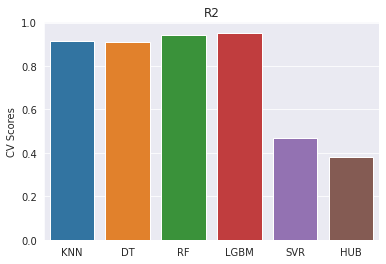

In [ ]:
# Visualization for mean R2 cross-validation scores 
plot_cv_scores(mod_list, ind_list, train_X, train_y, 10, 'r2')

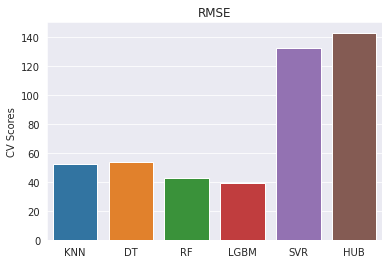

In [ ]:
# Visualization for mean RMSE cross-validation scores 
plot_cv_scores(mod_list, ind_list, train_X, train_y, 10, 'neg_mean_squared_error')

**Conclusion**: 

For LGBMRegressor R2 is the highest and RMSE is the smallest so this model will be used in next sections

# First variant - one target cnt

For this task we need to split data onto 2 trains and targets for corresponding 2011/2012 -> 0/1 year

Also cross-validation scores will be visualized for all models in this section in the end

In [ ]:
# Creating separate train and target for every year
train11 = train.query('yr == 0')
train12 = train.query('yr == 1')
target11 = data.query('yr == 0')['cnt']
target12 = data.query('yr == 1')['cnt']

Text(0.5, 1.0, 'Rental bikes count distribution vs year')

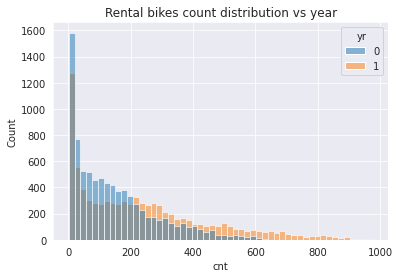

In [ ]:
# Checking target vs year
sns.histplot(data=data, x="cnt", hue="yr")
plt.title('Rental bikes count distribution vs year')

As we can see there is difference between years in rental bikes counts, for 2012 it is a little bit bigger

## 2011 separately

In [ ]:
# Creating lists for future use in plotting gained scores
cross_val_scores_all = []
mod_list = []

In [ ]:
# LGBMRegressor with best hyperparameters for 2011 year
lgbm11 = LGBMRegressor(bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.8, max_depth=13, min_data_in_leaf=90, n_estimators=1000, num_leaves=1200)
train_X, val_X, train_y, val_y = train_test_split(train11, target11, test_size = 0.20, random_state=0)

In [ ]:
# Fitting and estimating the model for 2011 year
fit_est_model(train_X, train_y, val_X, val_y, lgbm11, 'LGBM11')
cross_val_scores_all.append(cross_validate_r2(lgbm11, val_X, val_y, 5))
mod_list.append('LGBM11')

LGBM11
R2: 0.950686039783156
RMSE 29.77871872135794


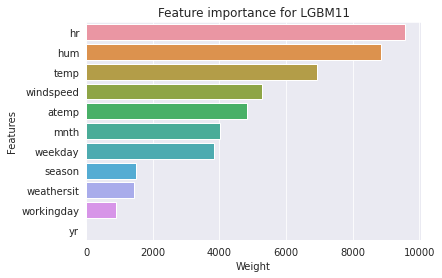

In [ ]:
# Feature importance for 2011
plot_importance(lgbm11, list(train.columns), 'LGBM11')

* As we can see for our LGBMRegressor on 2011 dataset score is slightly smaller then for the whole dataset, but still it is good
* The most important feature for 2011 is hr(hour), also hum, weekday and temp are in top 4

## 2012 separately

In [ ]:
# LGBMRegressor with best hyperparameters for 2012 year
lgbm12 = LGBMRegressor(bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.8, max_depth=13, min_data_in_leaf=90, n_estimators=1000, num_leaves=1200)
train_X, val_X, train_y, val_y = train_test_split(train12, target12, test_size = 0.20, random_state=0)

In [ ]:
# Fitting and estimating the model for 2012 year
fit_est_model(train_X, train_y, val_X, val_y, lgbm12, 'LGBM12')
cross_val_scores_all.append(cross_validate_r2(lgbm12, val_X, val_y, 5 ))
mod_list.append('LGBM12')

LGBM12
R2: 0.9601531040946629
RMSE 42.62338076850807


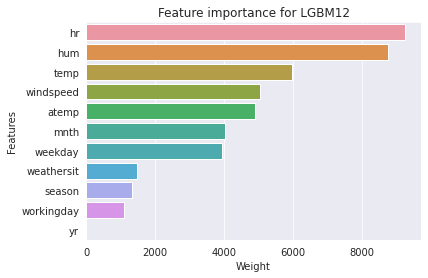

In [ ]:
# Feature importance for 2012
plot_importance(lgbm12, list(train.columns), 'LGBM12')

For 2012 estimation is better then for the whole dataset, most important features are the same as for 2011

## 2012 predicted from 2011

Now prediction for 2012 will be done based on 2011 data.
It will be in next order:
* First model will be trained with train 2011 data and validated with validation 2011 data
* Then new model will be trained with whole 2011 data and checked on 2012 data
* Results will be compared after that

In [ ]:
# First LGBMRegressor with best hyperparameters
lgbm11_2 = LGBMRegressor(bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.8, max_depth=13, min_data_in_leaf=90, n_estimators=1000, num_leaves=1200)
train_X, val_X, train_y, val_y = train_test_split(train11, target11, test_size = 0.20, random_state=0)

In [ ]:
# Fitting 2011 train dataset and estimating 2011 year on validation 2011 dataset
fit_est_model(train_X, train_y, val_X, val_y, lgbm11_2, 'LGBM11.2')
cross_val_scores_all.append(cross_validate_r2(lgbm11_2, val_X, val_y, 5))
mod_list.append('LGBM11.2')

LGBM11.2
R2: 0.950686039783156
RMSE 29.77871872135794


In [ ]:
# LGBMRegressor with best hyperparameters for both years 
lgbm_both = LGBMRegressor(bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.8, max_depth=13, min_data_in_leaf=90, n_estimators=1000, num_leaves=1200)

In [ ]:
# Fitting 2011 train dataset and estimating on 2012 year dataset
fit_est_model(train11, target11, train12, target12, lgbm_both, 'LGBM_BOTH')
cross_val_scores_all.append(cross_validate_r2(lgbm_both, train12, target12, 5))
mod_list.append('LGBM_BOTH')

LGBM_BOTH
R2: 0.6469280818394212
RMSE 124.37025778300652


As we can see when we try to predict 2012 target based on 2011 data score become worth

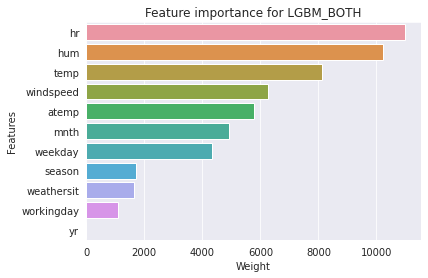

In [ ]:
# Feature importance for last model
plot_importance(lgbm_both, list(train.columns), 'LGBM_BOTH')

Now if to check feature importance then it is a little bgger weights for hum, temps and windspeed then for separated by year models. 

## Cross-validation visualization for models

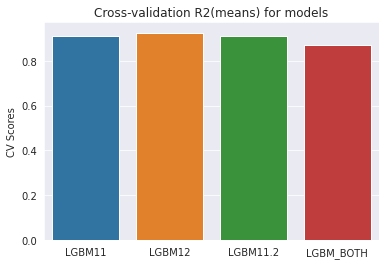

In [ ]:
# Comparing all cross-validation scores
plot_cv_mean_per_model(cross_val_scores_all, mod_list)

After cross-validation we can see the same in scores - for last one model it is the smallest

## Conclusion for onetarget model task:
* When we tried to predict Cnt of rental bikes for 2012 year based on 2011 year data we can see that score become smaller, it is explained by feature distributions differences between years and also difference for target between years.
* It was mentioned after visualizations that for 2011 year Cnt is smaller and for 2012 it is higher, and it is caused by some important features for Rental bikes counts
* That's when results of 2011 year are applied onto 2012 it is not working so good as for separate models
* Some improvements need to be done to make better prediction for future year



# Second variant - multitarget

Here every model will be estimated for every year and for 2 target - registered and casual bike rentals, and cross-validation scores will be checked for all models in the end

In [ ]:
# Creating separate targets for every year
target11_cas = data.query('yr == 0')['casual']
target11_reg = data.query('yr == 0')['registered']
target12_cas = data.query('yr == 1')['casual']
target12_reg = data.query('yr == 1')['registered']

## 2011 separately

### Registered target

In [ ]:
# LGBMRegressor with best hyperparameters
lgbm11_reg = LGBMRegressor(bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.8, max_depth=13, min_data_in_leaf=90, n_estimators=1000, num_leaves=1200)
train_X, val_X, train_y, val_y = train_test_split(train11, target11_reg, test_size = 0.20, random_state=0)

In [ ]:
# Fitting and estimating
reg_pred11 = fit_est_model(train_X, train_y, val_X, val_y, lgbm11_reg, 'LGBM11_reg')
cross_val_scores_all.append(cross_validate_r2(lgbm11_reg, val_X, val_y, 5))
mod_list.append('LGBM11_reg')

LGBM11_reg
R2: 0.9501367701625563
RMSE 24.50595591867517


### Casual target

In [ ]:
# LGBMRegressor with best hyperparameters
lgbm11_cas = LGBMRegressor(bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.8, max_depth=13, min_data_in_leaf=90, n_estimators=1000, num_leaves=1200)
train_X, val_X, train_y, val_y = train_test_split(train11, target11_cas, test_size = 0.20, random_state=0)

In [ ]:
# Fitting and estimating
cas_pred11 = fit_est_model(train_X, train_y, val_X, val_y, lgbm11_cas, 'LGBM11_cas')
cross_val_scores_all.append(cross_validate_r2(lgbm11_cas, val_X, val_y, 5))
mod_list.append('LGBM11_cas')

LGBM11_cas
R2: 0.9148541503427369
RMSE 11.212277312038267


As we can see on 2011 dataset for Registered as the target scores are slightly better than for Casual

## 2012 separately

### Registered target

In [ ]:
# LGBMRegressor with best hyperparameters
lgbm12_reg = LGBMRegressor(bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.8, max_depth=13, min_data_in_leaf=90, n_estimators=1000, num_leaves=1200)
train_X, val_X, train_y, val_y = train_test_split(train12, target12_reg, test_size = 0.20, random_state=0)

In [ ]:
# Fitting and estimating
reg_pred12 = fit_est_model(train_X, train_y, val_X, val_y, lgbm12_reg, 'LGBM12_reg')
cross_val_scores_all.append(cross_validate_r2(lgbm12_reg, val_X, val_y, 5))
mod_list.append('LGBM12_reg')

LGBM12_reg
R2: 0.9605319098740901
RMSE 35.54815936796026


### Casual target

In [ ]:
# LGBMRegressor with best hyperparameters
lgbm12_cas = LGBMRegressor(bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.8, max_depth=13, min_data_in_leaf=90, n_estimators=1000, num_leaves=1200)
train_X, val_X, train_y, val_y = train_test_split(train12, target12_cas, test_size = 0.20, random_state=0)

In [ ]:
# Fitting and estimating
cas_pred12 = fit_est_model(train_X, train_y, val_X, val_y, lgbm12_cas, 'LGBM12_cas')
cross_val_scores_all.append(cross_validate_r2(lgbm12_cas, val_X, val_y, 5))
mod_list.append('LGBM12_cas')

LGBM12_cas
R2: 0.9234178682399724
RMSE 16.188091477827072


For 2012 dataset the same for Registered as the target scores are slightly better than for Casual

## Cross-validation visualization for models

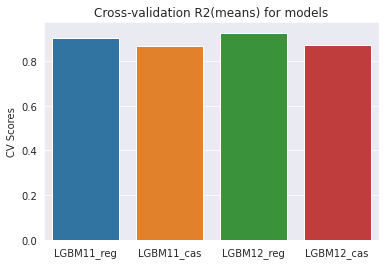

In [ ]:
# Comparing all scores for last 4 models
plot_cv_mean_per_model(cross_val_scores_all[-4:], mod_list[-4:])

Cross-validation shows the same that for registered target score is slightly better.

We can also check if feature importance differ for Registered and Casual

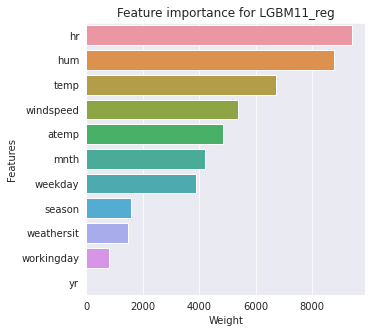

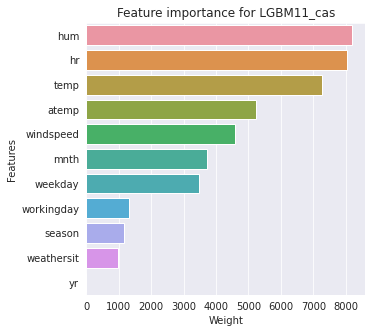

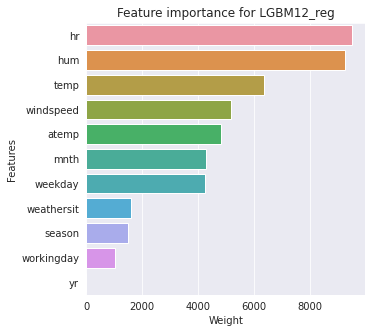

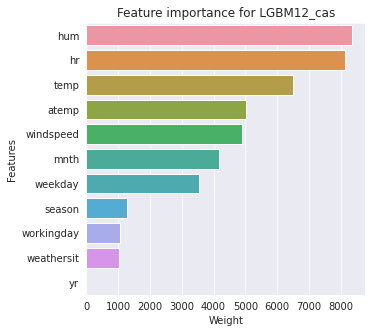

In [ ]:
# Feature importance for last 4 models
m_list = [lgbm11_reg, lgbm11_cas, lgbm12_reg, lgbm12_cas]
for i in range(0, 4):
  plt.subplots(figsize = (5, 5))
  plot_importance(m_list[i], list(train.columns), mod_list[-4:][i])

Here we can see that for Casual feeling temp(atemp) is more important then windspeed, for Registered vise versa. But tottally there is no big difference between feature importance for year or target selected. Here I'd like to answer some questions from task before next model.

In [ ]:
# Checking correlation coef for some features
data[['cnt', 'hum', 'temp', 'atemp']].corr()['cnt']

cnt      1.000000
hum     -0.334750
temp     0.402467
atemp    0.398543
Name: cnt, dtype: float64

Answering the questions about feature importance:

* Humidity is negatively correlated with rental bikes count, the lower humidity the higher count, and temperature is positively correlated. 
* Temperature is more important then feeling temperature(atemp) - it is visible on feature importance plot for all models and also in corr coef value.
* Most influential features are: hr(hour), hum(humidity), temp, windspeed for almost all models. This was checked on visualization of feature importance.
* Current hour is much more important then current season, it is confirmed with several visualizations and feature importance as well.

## Cnt predicted from Registered and Casual targets

Now to compare multitarget vs onetarget model we need to do the same as in the first task - to predict 2012 year on the 2011 year and then use those predicted values for Registered and Casual as sum to predict Cnt

In [ ]:
# Fitting 2011 train dataset and estimating on 2012 year dataset for every target
lgbm_both_m = LGBMRegressor(bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.8, max_depth=13, min_data_in_leaf=90, n_estimators=1000, num_leaves=1200)
reg_pred = fit_est_model(train11, target11_reg, train12, target12_reg, lgbm_both_m, 'LGBM_BOTH_reg')
cas_pred = fit_est_model(train11, target11_cas, train12, target12_cas, lgbm_both_m, 'LGBM_BOTH_cas')

LGBM_BOTH_reg
R2: 0.6242427022264851
RMSE 107.76896427375786
LGBM_BOTH_cas
R2: 0.7504079193226619
RMSE 28.531426562825764


What is interesting for this variant of dataset split score for Casual is better then for Registered

In [ ]:
# Summarizing predicted values and comparing with real Cnt values
sum = reg_pred+cas_pred
scores(target12, sum)

Sum reg+cas
R2: 0.6468016258228796
RMSE 124.39252797583798


**Conclusion**:
If we use the sum of two targets two predict cnt then estimation didn't become higher. It is almost the same as for one-target model. There we had R2=0.6469, RMSE=124.39.
Which is correct as Cnt is formed by registered and casual, which are independent each from other.